In [3]:
import cv2
from retinaface import RetinaFace

In [4]:
# Load your image
img_path = "query.JPG"
img = cv2.imread(img_path)

In [5]:
# Detect faces
faces = RetinaFace.detect_faces(img_path)

In [6]:
# Print the results
print(faces)
print(type(faces))

{'face_1': {'score': np.float64(0.9996070265769958), 'facial_area': [np.int64(1917), np.int64(1368), np.int64(2226), np.int64(1781)], 'landmarks': {'right_eye': [np.float32(2015.7351), np.float32(1515.7142)], 'left_eye': [np.float32(2158.1257), np.float32(1521.9303)], 'nose': [np.float32(2092.9736), np.float32(1605.3597)], 'mouth_right': [np.float32(2022.6517), np.float32(1670.3663)], 'mouth_left': [np.float32(2140.7993), np.float32(1675.3617)]}}, 'face_2': {'score': np.float64(0.9995579719543457), 'facial_area': [np.int64(1154), np.int64(332), np.int64(1454), np.int64(735)], 'landmarks': {'right_eye': [np.float32(1246.6127), np.float32(492.24893)], 'left_eye': [np.float32(1376.117), np.float32(512.5335)], 'nose': [np.float32(1302.1483), np.float32(572.82196)], 'mouth_right': [np.float32(1230.2517), np.float32(611.0654)], 'mouth_left': [np.float32(1353.6144), np.float32(628.06464)]}}, 'face_3': {'score': np.float64(0.9992601871490479), 'facial_area': [np.int64(1838), np.int64(519), np.

In [7]:
(faces)

{'face_1': {'score': np.float64(0.9996070265769958),
  'facial_area': [np.int64(1917),
   np.int64(1368),
   np.int64(2226),
   np.int64(1781)],
  'landmarks': {'right_eye': [np.float32(2015.7351), np.float32(1515.7142)],
   'left_eye': [np.float32(2158.1257), np.float32(1521.9303)],
   'nose': [np.float32(2092.9736), np.float32(1605.3597)],
   'mouth_right': [np.float32(2022.6517), np.float32(1670.3663)],
   'mouth_left': [np.float32(2140.7993), np.float32(1675.3617)]}},
 'face_2': {'score': np.float64(0.9995579719543457),
  'facial_area': [np.int64(1154),
   np.int64(332),
   np.int64(1454),
   np.int64(735)],
  'landmarks': {'right_eye': [np.float32(1246.6127), np.float32(492.24893)],
   'left_eye': [np.float32(1376.117), np.float32(512.5335)],
   'nose': [np.float32(1302.1483), np.float32(572.82196)],
   'mouth_right': [np.float32(1230.2517), np.float32(611.0654)],
   'mouth_left': [np.float32(1353.6144), np.float32(628.06464)]}},
 'face_3': {'score': np.float64(0.9992601871490479)

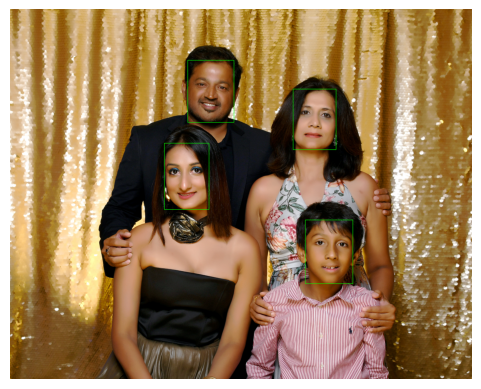

In [8]:
import matplotlib.pyplot as plt
import cv2
for key in faces.keys():
    identity = faces[key]
    x1, y1, x2, y2 = identity["facial_area"]

    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Convert BGR (cv2 format) → RGB (matplotlib format)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

In [9]:
from PIL import Image
crops = []
for key in faces.keys():
    x1, y1, x2, y2 = faces[key]["facial_area"]
    face = Image.open(img_path).crop((x1, y1, x2, y2))
    crops.append(face)

In [10]:
type(crops)

list

In [11]:
import numpy as np
from PIL import Image
from retinaface import RetinaFace

import torch
from facenet_pytorch import InceptionResnetV1

# -----------------------------
# Step 2: Load Facenet embedding model
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# pretrained="vggface2" (better generalization) or "casia-webface"
embedder = InceptionResnetV1(pretrained="vggface2").eval().to(device)

def preprocess(pil_face):
    # Facenet expects 160x160, scaled to [-1,1]
    arr = np.asarray(pil_face.resize((160,160))).astype(np.float32)
    t = torch.from_numpy(arr).permute(2,0,1) / 255.0        # [3,160,160], 0..1
    t = (t - 0.5) * 2.0                                     # scale to -1..1
    return t

# -----------------------------
# Step 3: Compute embeddings
# -----------------------------
batch = torch.stack([preprocess(c) for c in crops]).to(device)

with torch.no_grad():
    embeddings = embedder(batch).cpu().numpy()   # shape [N, 512]

print("Embeddings shape:", embeddings.shape)

Embeddings shape: (4, 512)


In [9]:
# -----------------------------
# Step 4: Compare with reference embeddings
# -----------------------------
def cosine_sim(a, b):
    a = a / np.linalg.norm(a, axis=-1, keepdims=True)
    b = b / np.linalg.norm(b, axis=-1, keepdims=True)
    return np.dot(a, b.T)

# Example: reference_embeddings = np.load("refs.npy")  # shape [M, 512]
# sims = cosine_sim(embeddings, reference_embeddings)  # [N, M]
# best_idx = sims.argmax(axis=1)
# best_scores = sims.max(axis=1)
# print(best_idx, best_scores)

In [10]:
len(embeddings)

4

In [14]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from PIL import Image
import torch

# Load processor and model
print("Loading BLIP-2 model...")
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("Model loaded successfully!")

# Load image
image = Image.open("query.JPG").convert("RGB")

# Prepare inputs
prompt = "Describe this image in detail."
inputs = processor(images=image, text=prompt, return_tensors="pt").to(device)

# Generate output
with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=200)

# Decode the output
description = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print("Image Description:", description)


Loading BLIP-2 model...


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Model loaded successfully!
Image Description: Describe this image in detail.



In [ ]:
# LLAVA !!
# ALTERNATIVE: Use smaller LLaVA model if you specifically need LLaVA 

from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch

try:
    # Try smaller LLaVA model
    model_id = "llava-hf/llava-1.5-7b-hf"  # More compatible version
    
    print("Loading LLaVA model...")
    processor = AutoProcessor.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        low_cpu_mem_usage=True,
        device_map="auto"
    )
    
    print("LLaVA model loaded successfully!")
    
    # Load image
    image = Image.open("query.JPG")
    
    # Generate description
    prompt = "USER: <image>\nDescribe this image in detail.\nASSISTANT:"
    inputs = processor(prompt, images=image, return_tensors="pt")
    
    # Generate response
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=200)
    
    # Decode and print
    description = processor.decode(output[0], skip_special_tokens=True)
    print("LLaVA Description:", description)
    
except Exception as e:
    print(f"LLaVA failed: {e}")
    print("Use the BLIP-2 solution above instead!")
